# Spatial analysis of Chicago burglary crime patterns 

## 1.0 Introduction and analysis context

### 1.1 Context and literature review

The continuous digitisation of police recorded crime statistics enables researchers and authorities to probe urban crime in depth. There are several related studies from different perspectives and using various computational techniques. From an academic and governing angle, spatial analysis of criminal activities plays an essential role in criminological research and policymaking (Andresen, 2005). Spatial analysis techniques, particularly DBSCAN,  help law enforcement safeguard crime-prone areas (Thakur, 2020). A spatial analysis of the burglary crime incidents could help policymakers allocate public and human resources to where they can be most effective. Relocating existing resources to crime hotspots identified by DBSCAN can have a positive investment return (Wheeler and Reuter, 2020).

Spatial patterns of the burglary that this project found can be associated with other local socio-economic factors to determine which kind of neighbourhoods are prone to burglaries (Craglia, Haining and Wiles, 2000). Several case studies show the link between local socio-economic factors and the crime rate. A significant correlation was found between the unemployment rate and crimes in an analysis of US data from 1974-2000 (Lin, 2008). Global datasets suggest that rising educational attainment leads to a reduction in criminal activities. One extra year's school education decreases burglary and larceny by around six per cent (Hjalmarsson & Lochner, 2012). One research of the City of Toronto finds crime hotspots in low-income areas while high in-come communities suffer a much lower crime rate (Charron, 2009). This project uses Chicago socio-economic datasets from the heartland alliance to build a model to predict crime rates in different communities.

### 1.2 Project goals

This project aims to provide a statistical spatial analysis of burglary crime incidents in Chicago and related visualisations. 
Appropriate clustering methods will identify clusters of crime incidents and administrative regions with a high burglary rate.
The underlaying socio-economic factors that correlate with high crime risk will be investigated by regression methods.

Goals bullet points and their potential real-world impacts:<br>

| Tasks | Task Categories | Real-world impacts |
| :---        |    :----  |          :--- |
| Identification of burglary crime clusters | Classification of point data | Crime control and preventation, a more efficient use of the police force |
| Identification of communities with exceptional burglary crime rat | Classification of polygons (administrative area) | Local policy change |
| Identification of socio-economic factors that correlate with burglary rate | Regression | Prediction of high-burglary-rate areas |

### 1.3 Data source 

The complete dataset of Chicago crime incidents from 2001 to the present is available through Chicago Data Portal. However, due to the scope of this analysis and the dataset's massive nature (over 7.5 million rows in March 2022), a filter is essential for obtaining a suitable subset, which contains burglary records only, and a swift data preprocessing and validation section. One way to implement such a filter is using a python package called sodapy, which is not available inside the SDS computing environment. An example is here: [github link]. The example python code needs an app token (registration with Chicago Data Portal required) and one line of NoSQL query to run. This project applies the 2019 dataset since the latest census data of Chicago is from 2019, and the 2020 global pandemic may introduce atypical variables.

Chicago crimes -2001 to Present: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-Present/ijzp-q8t2

The web page above includes metadata and column descriptions. Two columns, 'Latitude' and 'Longitude', make the geocoding of the point crime events possible.

The Data Portal offers shapefiles of Chicago wards. This project utilised shapefiles to provide an intuitive map of urban burglary density and risk.

Chicago Boundaries - Wards (2015 - ): https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Wards-2015-/sp34-6z76

The heartland alliance provides a range of community level socio-economic datasets.

Chicago communities datasets: https://www.heartlandalliance.org/heartland-alliance/research-and-policy/data-reports/chicago-data-dashboards/


This notebook merges the example Chicago dataset with spatial features of Chicago communities and socio-economic datasets to provide a more comprehensive analysis and visualisation beyond a simple point data pattern study.

### 1.4 Package requirement

In [1]:
import geopandas as gpd
import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point, Polygon
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import BallTree

## 2. Data preparation

### 2.1 Data Input

In [2]:
BURGLARY_2019 = pd.read_csv(
    "https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/BURGLARY_2019.csv"
)  # burglary records of Chicago 2019

chicago_community_pop = pd.read_csv(
    "https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/chicago_community_population.CSV"
)  # population of each Chicago commmunity

chicago_community = gpd.read_file(
    "/vsicurl/https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/geo_export_d1f0aa30-5958-4286-841c-d61250028149.shp"
)  # the shapefile of Chicago communities

median_household_income = pd.read_csv(
    "https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/MHI_data_average_median_household_income.csv"
)  # median household income of each Chicago commmunity

education = pd.read_csv(
    "https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/bach_data.csv"
)  # percentage of population with a college degree of each Chicago commmunity

unemply = pd.read_csv(
    "https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/unemply_data.csv"
)  # overall unemployment rate of each Chicago community

community_reference = pd.read_csv(
    "https://raw.githubusercontent.com/NijunJiang/CASA0006_2022/main/community_reference.csv"
)  # reference table for community name and number to reorder community socio-economics data

In the section below, there are five rows of the dataset. 

In [3]:
chicago_community_pop
chicago_community_pop.rename(columns={"No.": "community number"}, inplace=True)
chicago_community_pop.head()

,community number,Population
0,1,55628
1,2,77122
2,3,57182
3,4,40494
4,5,35114


In [4]:
community_type = ["community_dummy"] * len(chicago_community.index)
chicago_community["community_dummy"] = community_type
chicago_community = chicago_community.rename(columns={"area_numbe": "community number"})
chicago_community.head()

,area,area_num_1,community number,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,community_dummy
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844...",community_dummy
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816...",community_dummy
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801...",community_dummy
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816...",community_dummy
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816...",community_dummy


### 2.2 Data Preprocessing and Validation

Previous sections loaded datasets that this project will analyse. However, several data preprocessing steps should proceed before further analysis. The first step is data cleaning. In the 2019 dataset, there are over nine thousand rows of burglary records. To ensure a successful implementation of spatial analysis techniques (e.g. DBSCAN), filtering out rows that contain NULL, N/A, or zero values in the geographic location columns (e.g. latitude and longitude columns) is necessary. 

In [6]:
# Do not rerun the section after first attempt; otherwise the row number difference before and after the cleaning will not show
# Completeness check
before_clearning_size = BURGLARY_2019.shape[0]
BURGLARY_2019 = BURGLARY_2019[BURGLARY_2019["latitude"].notna()]
BURGLARY_2019 = BURGLARY_2019[BURGLARY_2019["longitude"].notna()]
after_clearning_size = BURGLARY_2019.shape[0]
print(
    "Before the first step of data cleaning, the 2019 dataset has "
    + str(before_clearning_size)
    + " rows."
    + " After cleaning, there are "
    + str(after_clearning_size)
    + " rows remaining"
)

Before the first step of data cleaning, the 2019 dataset has 9635 rows. After cleaning, there are 9635 rows remaining


It is also possible that there are duplicate incidents. The section below will drop potential duplicate rows based on three columns: case_number, id and location.

In [7]:
# Duplicate identification and elimination
before_clearning_size2 = BURGLARY_2019.shape[0]
BURGLARY_2019.drop_duplicates(subset=["id", "case_number", "location"])
after_clearning_size2 = BURGLARY_2019.shape[0]
print(
    "Before the second step of data cleaning, the 2019 dataset has "
    + str(before_clearning_size2)
    + " rows"
    + " After cleaning, there are "
    + str(after_clearning_size2)
    + " rows remaining"
)

Before the second step of data cleaning, the 2019 dataset has 9635 rows After cleaning, there are 9635 rows remaining


Fortunately, the Data Fulfillment and Analysis Section of the Chicago Police Department did not record any duplicate cases in 2019. The next step is data type checking. We require that location information is in numerical forms, such as float.

In [8]:
print("Column Latitude data type: " + str(BURGLARY_2019["latitude"].dtypes))
print("Column Longitude data type: " + str(BURGLARY_2019["longitude"].dtypes))

Column Latitude data type: float64
Column Longitude data type: float64


The data type of the two essential columns is, as expected, the float number. The final step of preprocessing should be outlier detection. However, due to the nature (official police records) of this 2019 dataset, it is unlikely that any data point is random. All rows have their wards and community numbers, which means removing isolated cases will reduce the burglary rate in administrative areas and cause bias. While applying DBSCAN, the algorithm will automatically disregard incidents that do not belong to any clusters. This project will not use statistical methods to detect and remove outlier events at the preprocessing stage.

### 2.3 Data Munging

There is one row of the burglary case record in the section below. Twenty-three columns provide a rich range of information, but not all of them are essential ingredients for a spatial study. Among them, four columns: ward, community area, latitude and longitude, will take part in the spatial analysis. Neither regression nor classification will use all remaining descriptive columns.

In [9]:
BURGLARY_2019.head(1)

,Unnamed: 0,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,0,11861297,JC473289,2019-10-13T20:30:00.000,077XX S CONSTANCE AVE,610,BURGLARY,FORCIBLE ENTRY,APARTMENT,False,...,8,43,5,1189882.0,1853924.0,2019,2019-10-20T16:03:03.000,41.754205,-87.579708,"{'latitude': '41.754205331', 'longitude': '-87..."


Important metadata:


|column name | column description |
| :---        |    :----  |
|id|Unique identifier for the record.|
|date|Date when the incident occurred. this is sometimes a best estimate.|
|ward|The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76|
|community Area | Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6|
|latitude|The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.|
|longitude|The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.|

In [10]:
# Removal of superfluous columns
BURGLARY_2019_spatial = BURGLARY_2019[
    ["id", "ward", "community_area", "latitude", "longitude"]
]

After reducing the complete dataset to a dataset with only municipal locations and coordinates in WSG84, pivot tables can provide an overview of the burglary case distribution across different levels of Chicago municipal districts.

In [11]:
# pivot tables initialisation
ward_count = BURGLARY_2019_spatial["ward"].value_counts()
community_count = BURGLARY_2019_spatial["community_area"].value_counts()

In [12]:
# override CSS to make multiple dataframes be able to display together
# https://softhints.com/display-two-pandas-dataframes-side-by-side-jupyter-notebook/
css = """
.output {
    flex-direction: row;
}
"""

HTML("<style>{}</style>".format(css))

In [13]:
# pivot tables sorting and display
community_count = community_count.sort_index()
community_count_frame = pd.DataFrame(
    {
        "community number": community_count.index,
        "burglary count 2019": community_count.values,
    }
)

ward_count = ward_count.sort_index()
ward_count_frame = pd.DataFrame(
    {"ward": ward_count.index, "burglary count 2019": ward_count.values}
)

display(community_count_frame.head())
display(ward_count_frame.head())

,community number,burglary count 2019
0,1,182
1,2,214
2,3,110
3,4,97
4,5,85


,ward,burglary count 2019
0,1,214
1,2,175
2,3,171
3,4,150
4,5,276


In the first five districts (ward or community), we can see the variation in incident numbers between different areas.

### 2.4 Data Merging

Given that community population data and total burglary incident numbers within communities are available, we can calculate the burglary rate (incidents per unit of population). The reason for choosing community-level analysis rather than ward is the ward is a political district, and ward boundaries change to reflect population shifts. Community borders, in contrast, are stable over time

In [14]:
crime_rate_2019_frame = pd.merge(
    community_count_frame, chicago_community_pop, on="community number"
)
crime_rate_2019_frame
crime_rate_2019_frame["incident rate per 1000 people"] = crime_rate_2019_frame[
    "burglary count 2019"
] / (
    crime_rate_2019_frame["Population"] / 1000
)  # new column, incident rate per 1000 people, based on two existing columns: burglary count 2019 and population

crime_rate_2019_frame

,community number,burglary count 2019,Population,incident rate per 1000 people
0,1,182,55628,3.271734
1,2,214,77122,2.774824
2,3,110,57182,1.923682
3,4,97,40494,2.395417
4,5,85,35114,2.420687
...,...,...,...,...
72,73,133,25065,5.306204
73,74,27,18628,1.449431
74,75,73,21186,3.445672
75,76,12,13418,0.894321


Append burglary statistical data to the community dataframe.

In [15]:
chicago_community["community number"] = chicago_community["community number"].astype(
    int
)
chicago_community_sorted = chicago_community.sort_values(by=["community number"])
chicago_community_with_crime_data = pd.merge(
    chicago_community_sorted, crime_rate_2019_frame, on="community number"
)
chicago_community_with_crime_data.head(1)

,area,area_num_1,community number,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,community_dummy,burglary count 2019,Population,incident rate per 1000 people
0,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",community_dummy,182,55628,3.271734


Append socio-economic factors to the burglary statistical dataframe.

In [16]:
# reorder dataframe indexing to make sure index is correlated with community number
unemply = unemply.set_index("Geography1")
unemply = unemply.reindex(index=community_reference["Name"])
unemply = unemply.reset_index()
unemply = unemply[["Name", "Estimate (copy)"]]

education = education.set_index("Geography1")
education = education.reindex(index=community_reference["Name"])
education = education.reset_index()
education = education[["Name", "Estimate (copy)"]]

median_household_income = median_household_income.set_index("Geography1")
median_household_income = median_household_income.reindex(
    index=community_reference["Name"]
)
median_household_income = median_household_income.reset_index()
median_household_income = median_household_income[["Name", "Estimate (copy)"]]

In [17]:
unemply.rename(columns={"Name": "community"}, inplace=True)
education.rename(columns={"Name": "community"}, inplace=True)
median_household_income.rename(columns={"Name": "community"}, inplace=True)

In [18]:
unemply['community'] = unemply['community'].str.upper()
education['community'] = education['community'].str.upper()
median_household_income['community'] = median_household_income['community'].str.upper()

In [19]:
unemply.rename(columns={"Estimate (copy)": "unemployment rate"}, inplace=True)
education.rename(columns={"Estimate (copy)": "degree percentage"}, inplace=True)
median_household_income.rename(columns={"Estimate (copy)": "median household income"}, inplace=True)

In [20]:
chicago_community_with_crime_data = pd.merge(
    chicago_community_with_crime_data, unemply, on="community"
)

chicago_community_with_crime_data = pd.merge(
    chicago_community_with_crime_data, education, on="community"
)

chicago_community_with_crime_data = pd.merge(
    chicago_community_with_crime_data, median_household_income, on="community"
)

In [21]:
chicago_community_with_crime_data.head(1)

,area,area_num_1,community number,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,community_dummy,burglary count 2019,Population,incident rate per 1000 people,unemployment rate,degree percentage,median household income
0,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",community_dummy,182,55628,3.271734,5.392294,45.410894,41753.5


## 3. Exploratory Data Analysis

### 3.1 Crime Map

With the help from the package geopandas, this section plots the visualisation of locations of crime events over the Chicago map. This raw represetation provides an intuitive impression, the burglary pattern does not have a even distribution across the space. Four south-east districts and a few north-west areas have fewer cases compared with remaining communities.

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
No handles with labels found to put in legend.


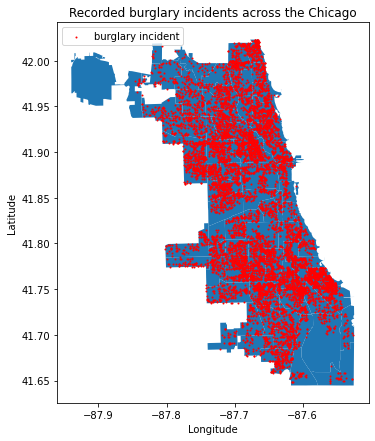

In [22]:
crs = {
    "init": "epsg:4326"
}  # coordinate reference system for the latitude and longitude


geometry = [
    Point(xy)
    for xy in zip(BURGLARY_2019_spatial["longitude"], BURGLARY_2019_spatial["latitude"])
]


geodata = gpd.GeoDataFrame(
    BURGLARY_2019_spatial, crs=crs, geometry=geometry
)  # burglary incident point data


fig, ax = plt.subplots(figsize=(10, 7))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Recorded burglary incidents across the Chicago")

chicago_community.plot(ax=ax, legend=True, column="community_dummy", categorical=True)
ax.legend()
ax.scatter(
    BURGLARY_2019_spatial["longitude"],
    BURGLARY_2019_spatial["latitude"],
    label="burglary incident",
    s=1,
    c="red",
)
ax.legend()

# some ideas from this article: https://www.linkedin.com/pulse/geopandas-plotting-data-points-map-using-python-r%C3%A9gis-nisengwe/

### 3.2 Community-level Crime Rate 

Text(0.5, 1.0, 'Incident rate per 1000 people (community level)')

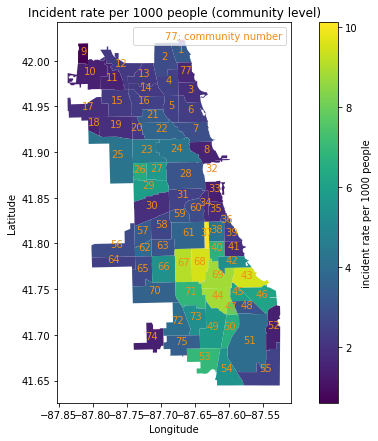

In [23]:
fig, ax = plt.subplots(figsize=(10, 7))
chicago_community_with_crime_data.plot(
    column="incident rate per 1000 people",
    ax=ax,
    legend=True,
    legend_kwds={"label": "incident rate per 1000 people"},
)
chicago_community.apply(
    lambda x: ax.annotate(
        text=x["community number"],
        xy=x.geometry.centroid.coords[0],
        ha="center",
        color="#ee8d18",
    ),
    axis=1,
)

plt.plot([], [], " ", label="77: community number")
legend = plt.legend()
plt.setp(legend.get_texts(), color="#ee8d18")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Incident rate per 1000 people (community level)")

Southern communities have a higher burglary rate than their northern counterparts.

Text(0.5, 1.0, 'Total 2019 burglary count in each Chicago community')

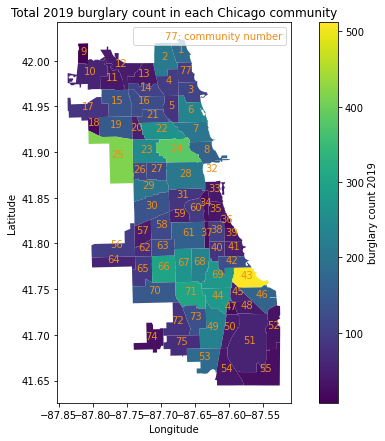

In [24]:
fig, ax = plt.subplots(figsize=(10, 7))
chicago_community_with_crime_data.plot(
    column="burglary count 2019",
    ax=ax,
    legend=True,
    legend_kwds={"label": "burglary count 2019"},
)
chicago_community.apply(
    lambda x: ax.annotate(
        text=x["community number"],
        xy=x.geometry.centroid.coords[0],
        ha="center",
        color="#ee8d18",
    ),
    axis=1,
)

plt.plot([], [], " ", label="77: community number")
legend = plt.legend()
plt.setp(legend.get_texts(), color="#ee8d18")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Total 2019 burglary count in each Chicago community")

The difference between communities is less apparent in terms of total record number. Community 43 has the highest number among all others. Communities adjacent to the community 24 and 71 tend to have a higher total count than the other communities.

## 3. Methodology

### 3.1 DBSCAN (clustering)

A range of clustering methods, including the DBSCAN algorithm, K - Nearest Neighbor and Artificial Neural Network, were applicable to crime pattern mapping (Mungekar et al., 2021). This project will not evaluate different methods' performance. The choice of the approach is based on a study analysing six Indian cities. During the research, DBSCAN outperforms K-Means clustering and Agglomerative hierarchical clustering in terms of recall and precision (Sivaranjani, Sivakumari and Aasha, 2016).

DBSCAN (density-based spatial clustering of applications with noise) groups crowded points into groups and determines whether other points belong to any clusters. DBSCAN is an unsupervised learning method that requires two hyperparameters (epsilon, which determines the Euclidean searching radius of the data point; minPoints, which is the minimum number of other data points inside the search radius for the central data point to become a core point) to initialise. Within the search radius, if a point finds n (greater than zero but smaller than minPoints) other points, the point becomes a border point. The DBCAN algorithm first identifies and connects core points to form clusters and then connects border points to suitable clusters. A point that finds no other point within the search radius becomes a noise point. (Ester et al., 1996)

## 4. Data Analysis

### 4.1 DBSCAN 

#### 4.1.1 DBSCAN Hyperparameter Tuning

According to a case study (Rahmah and Sitanggang, 2016), an ascending plot of each point's distance to the nearest point can determine an optimal epsilon. The y-axis coordinate of the location, which has a significant slope change, is the suitable epsilon value. The Chicago crime data offers incident locations in latitude and longitude, bringing an extra layer of complexity during the distance calculation. Instead of a simple 2-D Euclidean distance equation, latitude and longitude pairs (spherical coordinates) need to use the haversine formula to find distance values between them. This section implements the haversine formula through the Balltree algorithm to solve the nearest neighbour problem.

The choice of the minPoints value depends on domain knowledge or the dimension of the dataset. In a study of the extended DBSCAN algorithm, network-space DBSCAN (NS-DBSCAN), an explicitly modified DBSCAN for the urban environment, applies MinPts = 20 for clustering (Wang, Ren, Luo and Tian, 2019).

In [50]:
# parts of code adopted from https://stackoverflow.com/questions/61952561/how-do-i-find-the-neighbors-of-points-containing-coordinates-in-python
DBSCANdf = BURGLARY_2019_spatial

# Setup Balltree using df as reference dataset
# Use Haversine calculate distance between points on the earth from lat/long
# haversine - https://pypi.org/project/haversine/
tree = BallTree(
    np.deg2rad(DBSCANdf[["latitude", "longitude"]].values), metric="haversine"
)


DBSCANdf_query = BURGLARY_2019_spatial

qlats = DBSCANdf_query["latitude"]
qlons = DBSCANdf_query["longitude"]

# use k = 2 for 1 closest neighbor (excluding the point itself)
distances, inx = tree.query(np.deg2rad(np.c_[qlats, qlons]), k=2)

distance_list = []
r_km = 6371  # multiplier to convert to km (from unit distance)
for name, d, ind in zip(DBSCANdf_query["id"], distances, inx):
    for i, index in enumerate(ind):
        distance_list.append(d[i] * r_km)

In [51]:
distance_list = [
    i for i in distance_list if i != 0
]  # remove zeros (distance to the point itself)
distance_list.sort()

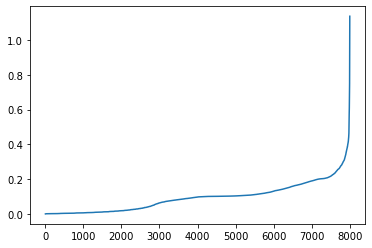

In [52]:
plt.plot(distance_list)

The plot has an 'elbow' when the y value is around 0.35 km. 

#### 4.1.2 DBSCAN Result Visualisation

In [102]:
kms_per_radian = 6371.0088
epsilon = 0.35 / kms_per_radian
min_samples = 20


def DBfunction(data, epsilon, minsample):
    DBSCAN_result = data
    coords = DBSCAN_result[["latitude", "longitude"]].to_numpy()
    db = DBSCAN(
        eps=epsilon, min_samples=min_samples, algorithm="ball_tree", metric="haversine"
    ).fit(np.radians(coords))
    DBSCAN_result["DBSCAN_opt_labels"] = db.labels_
    DBSCAN_result["DBSCAN_opt_labels"].value_counts()
    return DBSCAN_result


DBSCAN_result = DBfunction(
    data=BURGLARY_2019_spatial, epsilon=epsilon, minsample=min_samples
)
len(DBSCAN_result["DBSCAN_opt_labels"].value_counts())

55

The silhouette score is 0.4401230161702594


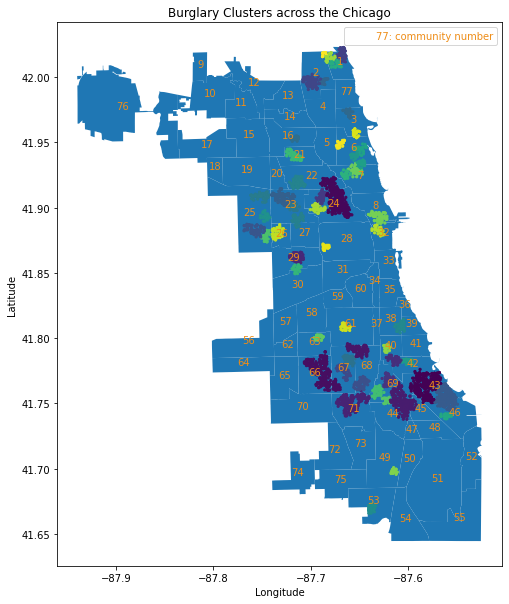

In [105]:
def dbPlot(DBSCAN_result):
    DBSCAN_result_withoutNoise = DBSCAN_result.drop(
        DBSCAN_result[DBSCAN_result.DBSCAN_opt_labels == -1].index
    )  # remove points that do not belong to a cluster (noise)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Burglary Clusters across the Chicago")

    chicago_community.plot(
        ax=ax, legend=True, column="community_dummy", categorical=True
    )
    chicago_community.apply(
        lambda x: ax.annotate(
            text=x["community number"],
            xy=x.geometry.centroid.coords[0],
            ha="center",
            color="#ee8d18",
        ),
        axis=1,
    )
    ax.scatter(
        DBSCAN_result_withoutNoise["longitude"],
        DBSCAN_result_withoutNoise["latitude"],
        c=DBSCAN_result_withoutNoise["DBSCAN_opt_labels"],
        s=5,
    )

    plt.plot([], [], " ", label="77: community number")
    legend = plt.legend()
    plt.setp(legend.get_texts(), color="#ee8d18")
    score = metrics.silhouette_score(DBSCAN_result_withoutNoise[["latitude", "longitude"]].to_numpy(), DBSCAN_result_withoutNoise["DBSCAN_opt_labels"], metric='euclidean')
    print('The silhouette score is ' + str(score))
    
dbPlot(DBSCAN_result=DBSCAN_result)

The algorithm spots 54 clusters of burglary crime in Chicago. Some areas (e.g. community 25, community 24 and community 67) have multiple clusters, while several northeast regions (e.g. community 17 & 11) and middle sections (e.g. community 56 and 31) have no clusters. 

#### 4.1.3 Qualitative description of DBSCAN Clusters and Discussion

In [121]:
print('On average, one cluster have ' + str(DBSCAN_result["DBSCAN_opt_labels"].value_counts().drop(labels=[-1]).mean()) +' records')

On average, one cluster have 69.88888888888889 records


The silhouette score (between -1 and 1) is 0.4401230161702594, indicating an acceptable clustering quality, and clusters are not likely to be overlapped or mislabelled. Each cluster, on average, contains near 70 recorded burglary incidents. The clusters are mainly congested into two areas: northern communities around community 24 and southern communities near community 69. Between two regions with a relatively high density of clusters, a buffer zone, namely, community 56-60 and community 33-36, has no cluster. Further in southern Chicago, two clusters scatter over the community 49 and 53, and in the northwest of the city, DBSCAN detects no cluster.

#### 4.1.4 DBSCAN Visualisation With Temporal Constraints

In this section 4.1.2, the visualisation of burglary clusters is complete. However, there is a significant issue undermining the value of the finding, cases inside clusters correlate with each other in the spatial domain, but temporal distances between points are neglected. We must consider the time timestamp for real-world problems (e.g. should a December case be associated with a cluster of multiple January records in the area?). This section assumes a scenario in which the authority requires a crime analysis of the first five months of 2019.

The silhouette score is 0.884651826654697


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


-1    3446
 0      78
 1      56
 2      25
Name: DBSCAN_opt_labels, dtype: int64

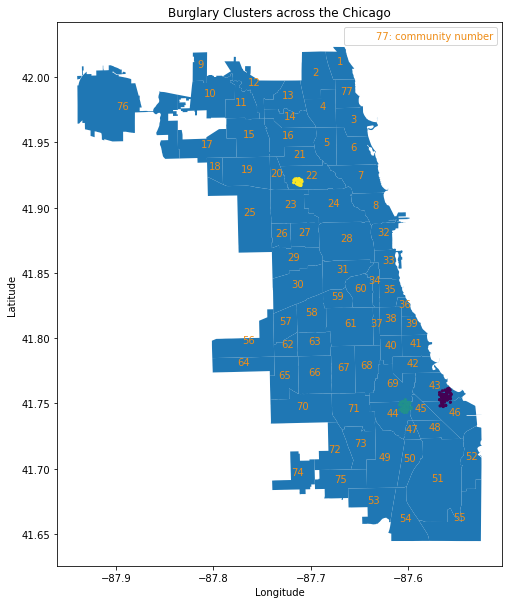

In [118]:
BURGLARY_2019["date"] = pd.to_datetime(BURGLARY_2019["date"])

BURGLARY_2019 = BURGLARY_2019.sort_values(by=["date"])

mask = (BURGLARY_2019["date"] > "2019-1-1") & (BURGLARY_2019["date"] <= "2019-5-30")
BURGLARY_2019_JAN = BURGLARY_2019.loc[mask]

BURGLARY_2019_JAN_result = DBfunction(
    data=BURGLARY_2019_JAN, epsilon=epsilon, minsample=min_samples
)
dbPlot(DBSCAN_result=BURGLARY_2019_JAN_result)
BURGLARY_2019_JAN_result["DBSCAN_opt_labels"].value_counts()

In [120]:
print('On average, one cluster have ' + str(BURGLARY_2019_JAN_result["DBSCAN_opt_labels"].value_counts().drop(labels=[-1]).mean()) +' records')

On average, one cluster have 53.0 records


A temporal constraint reduces the total number of clusters by 51 (from 54 to 3). The largest cluster in this scenario has 78 cases. During the first five months of 2019, DBSCAN finds one cluster in community 22, another one at the northeast corner of community 44, and a third across the border between community 43 and 46.

#### 4.1.5 DBSCAN Further Work

With one additional hyperparameter, temporal maximum reachable distance, an extended DBSCAN becomes ST-DBSCAN, allowing point data to search neighbouring events in the temporal domain (Chen and Cheng 2020). The rigid temporal constraint in section 4.1.3 may partially solve the temporal correlation issue. Still, it has a border problem (i.e. if the temporal boundary is 1st May, a case that occurred on 2nd May will not associate with any previous cases).

The package st_dbscan is not available in the coursework environment.

# Bibliography

FBI UCR. 2019. Burglary. [online] Available at: <https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019/topic-pages/burglary> [Accessed 17 March 2022].

Craglia, M., Haining, R. and Wiles, P., 2000. A Comparative Evaluation of Approaches to Urban Crime Pattern Analysis. Urban Studies, 37(4), pp.711-729.

Andresen, M., 2005. Crime Measures and the Spatial Analysis of Criminal Activity. The British Journal of Criminology, 46(2), pp.258-285.

Mungekar, D., Joshi, H., Kankekar, A., Nair, P. and Das, P., 2021. Crime Analysis using DBSCAN Algorithm. 2021 Third International Conference on Inventive Research in Computing Applications (ICIRCA),.

Sivaranjani, S., Sivakumari, S. and Aasha, M., 2016. Crime prediction and forecasting in Tamilnadu using clustering approaches. 2016 International Conference on Emerging Technological Trends (ICETT),.

Ester, M., Kriegel, H.-P., Sander, J., & Xu, X. (1996). A density-based algorithm for discovering clusters in large spatial databases with noise. 226–231.

Rahmah, N. and Sitanggang, I., 2016. Determination of Optimal Epsilon (Eps) Value on DBSCAN Algorithm to Clustering Data on Peatland Hotspots in Sumatra. IOP Conference Series: Earth and Environmental Science, 31, p.012012.

Roshan P. Thakur, 2020. CRIME ANALYSIS AND PREDICTION - BY USING DBSCAN ALGORITHM. International Research Journal of Engineering and Technology (IRJET), 7(4), pp. 4262 - 4266

Hjalmarsson, Randi & Lochner, Lance. (2012). The Impact of Education on Crime: International Evidence. CESifo Dice Report, Journal for Institutional Comparisons. 10. 

Lin, M., 2008. Does Unemployment Increase Crime?: Evidence from U.S. Data 1974-2000. Journal of Human Resources, 43(2), pp.413-436.

Charron, M. 2009. Neighbourhood Characteristics and the Distribution of Police-reported Crime in the City of Toronto. Canadian Centre For Justice Statistics. Catalogue no. 85-561-M, no. 18

Wheeler, A. and Reuter, S., 2020. Redrawing Hot Spots of Crime in Dallas, Texas. Police Quarterly, 24(2), pp.159-184.

Wang, T., Ren, C., Luo, Y. and Tian, J., 2019. NS-DBSCAN: A Density-Based Clustering Algorithm in Network Space. ISPRS International Journal of Geo-Information, 8(5), p.218.

In [108]:
DBSCAN_result["DBSCAN_opt_labels"].value_counts()

-1     5861
 0      356
 4      299
 1      291
 2      273
 15     261
 5      208
 16     107
 3       94
 11      93
 14      80
 42      72
 22      70
 13      68
 10      66
 24      63
 8       62
 6       59
 48      59
 12      57
 7       54
 36      51
 37      49
 41      48
 25      47
 23      45
 9       43
 46      43
 47      43
 20      42
 31      36
 27      35
 38      34
 33      32
 18      31
 29      31
 35      30
 21      29
 49      29
 26      29
 34      29
 45      28
 30      28
 50      27
 52      27
 40      26
 28      25
 32      25
 39      23
 51      23
 17      22
 44      21
 19      20
 43      20
 53      11
Name: DBSCAN_opt_labels, dtype: int64

In [110]:
type(DBSCAN_result["DBSCAN_opt_labels"].value_counts().drop(labels=[-1]))

pandas.core.series.Series

In [115]:
DBSCAN_result["DBSCAN_opt_labels"].value_counts().drop(labels=[-1]).mean()

69.88888888888889